<a href="https://colab.research.google.com/github/FatimaEzzedinee/ML-bachelor-course-labs-sp24/blob/main/08_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning SP 2023/2024

- Prof. Cesare Alippi
- Alvise Dei Rossi ([`alvise.dei.rossi@usi.ch`](mailto:alvise.dei.rossi@usi.ch))<br>
- Fatima Ezzeddine ([`fatima.ezzeddine@usi.ch`](mailto:fatima.ezzeddine@usi.ch))<br>
- Alessandro Manenti ([`alessandro.manenti@usi.ch`](mailto:alessandro.manenti@usi.ch))

---
# Lab 08: Forecasting


## Forecasting sunspots

![](https://upload.wikimedia.org/wikipedia/commons/4/47/Solar_Archipelago_-_Flickr_-_NASA_Goddard_Photo_and_Video.jpg)

As a case study we will cosider the problem of forecasting the number of **sunspots** using a dataset collected by the solar physics research department of the Royal Observatory of Belgium ([link](http://sidc.oma.be/)).

According to Wikipedia:

> Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

The datset is available on Kaggle ([link](https://www.kaggle.com/robervalt/sunspots)) and frequently updated.

For semplicity (and reproducibility), we loaded a snapshot of the dataset in the repo of the course.

We start by installing the last version of statsmodels.

In [ ]:
%pip install statsmodels -U

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/FatimaEzzedinee/ML-bachelor-course-labs-sp24/main/sunspots.csv"

df = pd.read_csv(url,
                 parse_dates=True,
                 index_col='Date',
                 usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df = df.rename(columns={'Monthly Mean Total Sunspot Number':'sunspots'})

In [ ]:
df.head()

,sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


__Note__: the time series we're considering since $d=1$ is said to be _univariate_.

Let's have a look at the data!

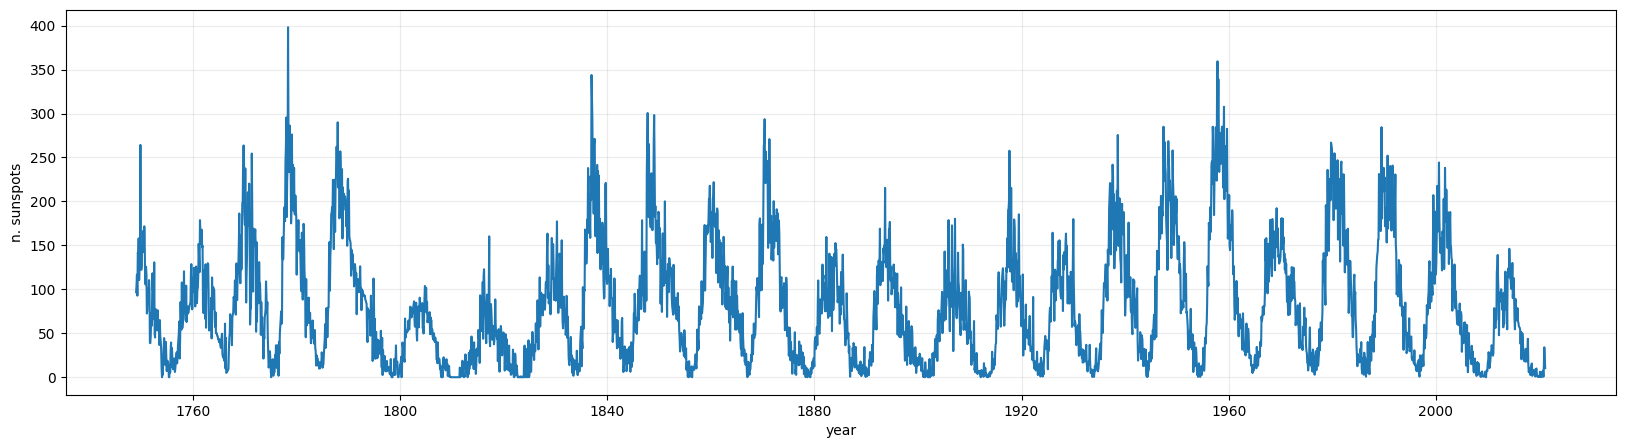

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df['sunspots'])
plt.xlabel('year')
plt.ylabel('n. sunspots')
plt.grid(alpha=0.25)
plt.show()

First of all let's split our data for model evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare the data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# scale the data
mean = train_df.values.mean()
std = train_df.values.std()

scale = lambda x : (x - mean) / std
inv_scale = lambda x : x * std + mean

train_df = scale(train_df)
test_df = scale(test_df)

# Note that you could do this completely in sklearn with:
# from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
# X_train = scaler.fit_transform(train_df)
# X_test = scaler.transform(test_df)

# THERE IS AN ERROR BEFORE, CAN YOU SPOT IT?

## A simple baseline

Simply use the value at the previous time-step to predict the next one:
$$\hat{y}_{t+1} = x_t$$
This is usually called a Naïve method.

BASELINE MSE: 636.9892484662575
BASELINE MAE: 18.23021472392638


KeyboardInterrupt: 

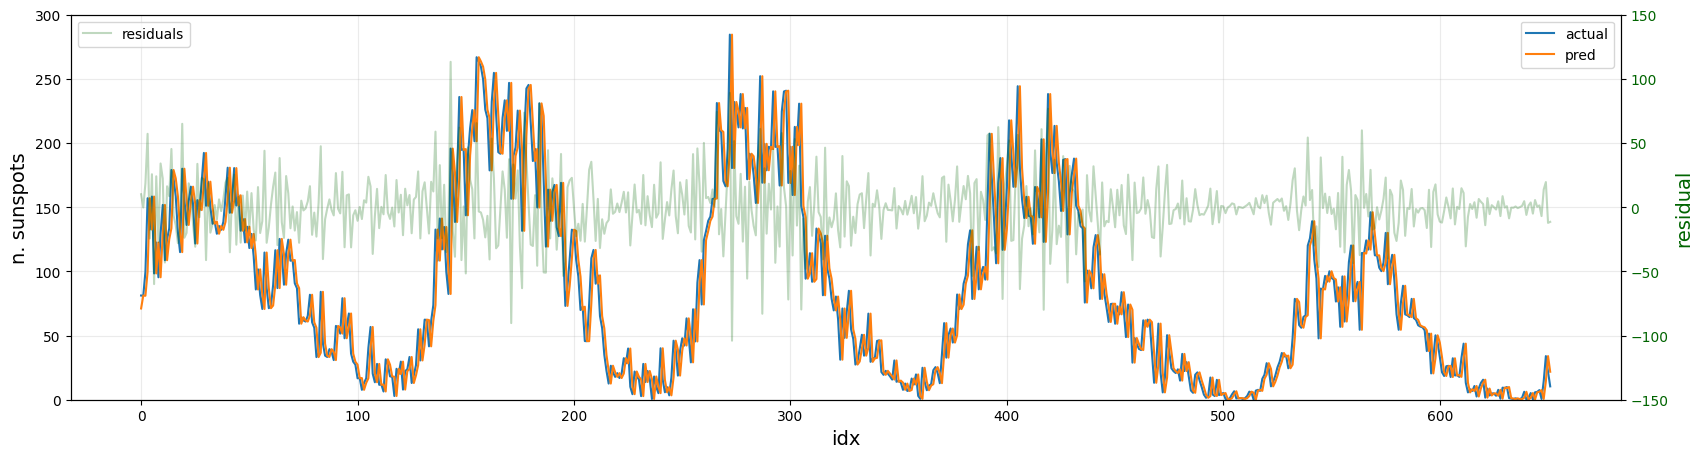

In [ ]:
actuals = inv_scale(test_df.values.ravel())

mse = np.square(actuals[:-1] - actuals[1:]).mean()
print(f"BASELINE MSE: {mse}")
mae = np.abs(actuals[:-1] - actuals[1:]).mean()
print(f"BASELINE MAE: {mae}")

fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(actuals[1:], label='actual')
ax1.plot(actuals[:-1], label='pred')
ax1.set_ylabel('n. sunspots',fontsize=14)
ax1.set_xlabel('idx',fontsize=14)
ax1.set_ylim([0,300])
plt.legend(loc="upper right")
plt.grid(alpha=0.25)
ax2 = ax1.twinx()
ax2.set_ylabel('residual', color="darkgreen", fontsize=14)
ax2.plot(actuals[1:] - actuals[:-1], color="darkgreen", alpha=0.25,label="residuals")
ax2.tick_params(axis='y', labelcolor="darkgreen")
ax2.set_ylim([-150,150])
plt.legend(loc="upper left")
fig.tight_layout()

plt.show()

The fit looks almost perfect, but we should look at the residuals to evaluate the fit. The mismatch between predictions and the actual values can also be seen by zooming in on smaller windows:

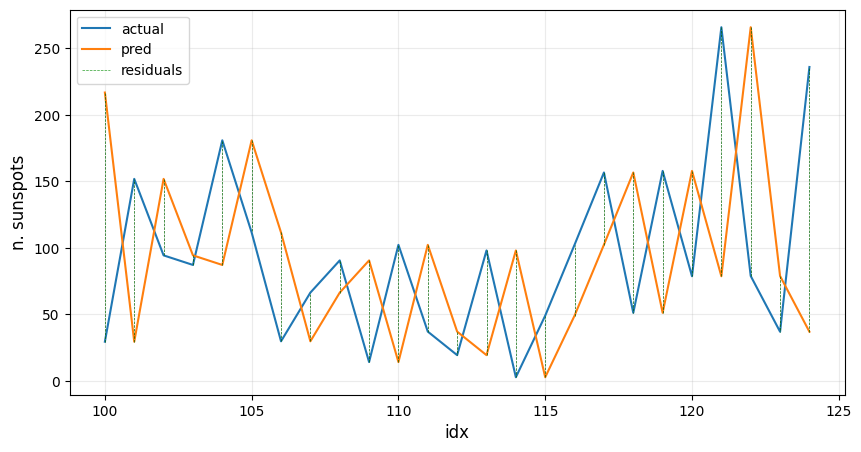

In [ ]:
from matplotlib import collections  as mc

lines = [[(i, actuals[i-1]), (i, actuals[i])] for i in range(100,125)]
lc = mc.LineCollection(lines, linewidths=0.5, linestyle="--", colors="darkgreen")

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(range(100,125),actuals[100:125], label='actual')
ax1.plot(range(100,125),actuals[99:124], label='pred')
ax1.plot([],[],label="residuals",linestyle="--",linewidth=0.5) # fake plot for legend
ax1.set_ylabel('n. sunspots',fontsize=12)
ax1.set_xlabel('idx',fontsize=12)
ax1.add_collection(lc)
plt.legend(loc="upper left")
plt.grid(alpha=0.25)
plt.show()

## Linear models

Let's start with ARIMA models. You can find the documentation [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html).

As a reminder. An autoregressive model of order p (AR(p)) model is a linear model which considers for the prediction the past p realizations:

$$ \hat{y}_t = \phi_1 x_{t-1} + ... + \phi_p x_{t-p} + c = c + \sum_{i=1}^p \phi_i x_{t-i}$$

A moving average model of order q (MA(q)) is a linear model which considers for the prediction the past q forecasting errors, i.e. defining the residual as $\hat{\eta}_t = y_t - \hat{y}_t$, a MA(q) model gives predictions:

$$\hat{y}_t = \theta_1 \hat{\eta}_{t-1} + ... + \theta_q \hat{\eta}_{t-q} + c = c + \sum_{i=1}^q \theta_i \hat{\eta}_{t-i}; \quad \quad \eta_t \sim WN(0, \sigma^2)$$

Note that this is **NOT** a moving average smoothing.

If you include both the autoregressive and moving average components, you get ARMA(p,q) models. To deal with non-stationary time-series, you need to include also differentiation, i.e. $x'(t) = x_t - x_{t-d}$, to get an ARIMA(p, d, q) model.

Let's start with an AR(p) model:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#order refers to (p,d,q) , often called also (p,i,q)
model = ARIMA(train_df, order=(3, 0, 0), trend='n')

fit = model.fit()
print(fit.summary())

# appends test_df to avaiable data
fit = fit.append(test_df, refit=False)

actuals = test_df.values.ravel()
preds = fit.predict(start=len(train_df)).values.ravel()

mse = np.square(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"\n\nTEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MAE: {mae}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                 2612
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1201.162
Date:                Fri, 31 May 2024   AIC                           2410.323
Time:                        06:11:31   BIC                           2433.795
Sample:                    01-31-1749   HQIC                          2418.826
                         - 08-31-1966                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6119      0.014     42.412      0.000       0.584       0.640
ar.L2          0.1483      0.017      8.792      0.000       0.115       0.181
ar.L3          0.1886      0.015     12.603      0.0

Now let's try with a MA(q) model:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

#ARIMA(p,i,q)
model = ARIMA(train_df, order=(0, 0, 2), trend='n')

fit = model.fit()
print(fit.summary())

# appends test_df to avaiable data
fit = fit.append(test_df, refit=False)

actuals = test_df.values.ravel()
preds = fit.predict(start=len(train_df)).values.ravel()

mse = np.square(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"\n\nTEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MAE: {mae}")

                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                 2612
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -2197.814
Date:                Fri, 31 May 2024   AIC                           4401.628
Time:                        06:12:01   BIC                           4419.232
Sample:                    01-31-1749   HQIC                          4408.005
                         - 08-31-1966                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9085      0.014     63.303      0.000       0.880       0.937
ma.L2          0.4995      0.014     35.359      0.000       0.472       0.527
sigma2         0.3149      0.006     52.285      0.0

That was quite bad... what about combining them?

In [ ]:
#ARIMA(p,i,q)
model = ARIMA(train_df, order=(3, 0, 2), trend='n')

fit = model.fit()
print(fit.summary())

# appends test_df to avaiable data
fit = fit.append(test_df, refit=False)

actuals = test_df.values.ravel()
preds = fit.predict(start=len(train_df)).values.ravel()

mse = np.square(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"\n\nTEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MAE: {mae}")

                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                 2612
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1115.603
Date:                Fri, 31 May 2024   AIC                           2243.205
Time:                        06:12:10   BIC                           2278.413
Sample:                    01-31-1749   HQIC                          2255.959
                         - 08-31-1966                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3112      0.022    103.304      0.000       2.267       2.355
ar.L2         -1.6580      0.044    -37.374      0.000      -1.745      -1.571
ar.L3          0.3453      0.023     15.289      0.0

Much better.. Do we need also the differentiation?

In [ ]:
#ARIMA(p,i,q)
model = ARIMA(train_df, order=(3, 1, 2), trend='n')

fit = model.fit()
print(fit.summary())

# appends test_df to avaiable data
fit = fit.append(test_df, refit=False)

actuals = test_df.values.ravel()
preds = fit.predict(start=len(train_df)).values.ravel()

mse = np.square(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"\n\nTEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MAE: {mae}")

                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                 2612
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1146.441
Date:                Fri, 31 May 2024   AIC                           2304.881
Time:                        06:17:41   BIC                           2340.086
Sample:                    01-31-1749   HQIC                          2317.634
                         - 08-31-1966                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3555      0.023     59.204      0.000       1.311       1.400
ar.L2         -0.3646      0.025    -14.650      0.000      -0.413      -0.316
ar.L3         -0.0455      0.019     -2.447      0.0

Seems to obtain about the same results, let's see its predictions:

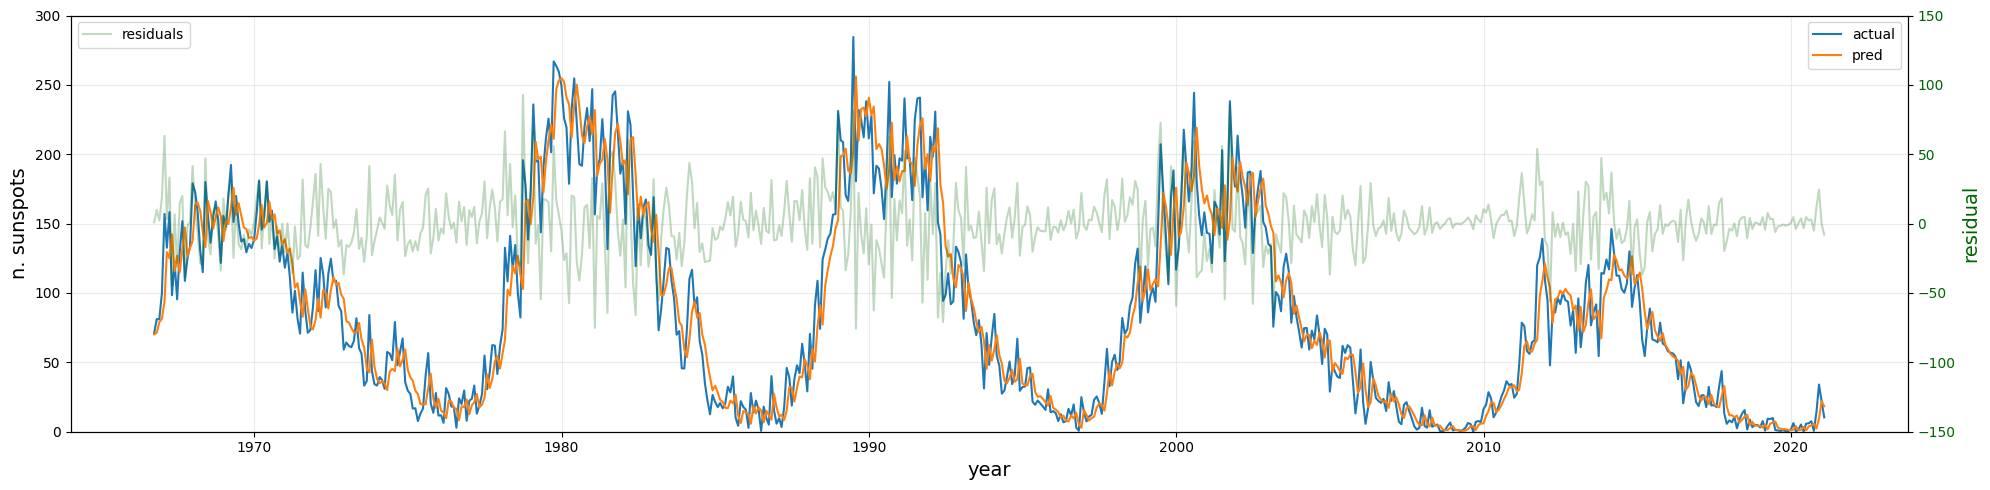

In [ ]:
preds = fit.predict(start=len(train_df), dynamic=False)

fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(inv_scale(test_df), label='actual')
ax1.plot(inv_scale(preds), label='pred')
ax1.set_ylabel('n. sunspots',fontsize=14)
ax1.set_xlabel('year',fontsize=14)
ax1.set_ylim([0,300])
plt.legend(loc="upper right")
plt.grid(alpha=0.25)
ax2 = ax1.twinx()
ax2.set_ylabel('residual', color="darkgreen", fontsize=14)
ax2.plot(inv_scale(actuals) - inv_scale(preds), color="darkgreen", alpha=0.25,label="residuals")
ax2.tick_params(axis='y', labelcolor="darkgreen")
ax2.set_ylim([-150,150])
plt.legend(loc="upper left")
fig.tight_layout()

plt.show()

In [ ]:
lines

[[(100, array([29.6])), (100, array([27.3]))],
 [(101, array([27.3])), (101, array([16.7]))],
 [(102, array([16.7])), (102, array([16.9]))],
 [(103, array([16.9])), (103, array([7.7]))],
 [(104, array([7.7])), (104, array([13.1]))],
 [(105, array([13.1])), (105, array([16.7]))],
 [(106, array([16.7])), (106, array([40.4]))],
 [(107, array([40.4])), (107, array([56.7]))],
 [(108, array([56.7])), (108, array([20.3]))],
 [(109, array([20.3])), (109, array([13.6]))],
 [(110, array([13.6])), (110, array([27.9]))],
 [(111, array([27.9])), (111, array([11.6]))],
 [(112, array([11.6])), (112, array([11.9]))],
 [(113, array([11.9])), (113, array([6.4]))],
 [(114, array([6.4])), (114, array([31.5]))],
 [(115, array([31.5])), (115, array([27.3]))],
 [(116, array([27.3])), (116, array([18.2]))],
 [(117, array([18.2])), (117, array([17.9]))],
 [(118, array([17.9])), (118, array([2.9]))],
 [(119, array([2.9])), (119, array([24.1]))],
 [(120, array([24.1])), (120, array([20.]))],
 [(121, array([20.])

In [ ]:
test_df.index[100:125]

DatetimeIndex(['1975-01-31', '1975-02-28', '1975-03-31', '1975-04-30',
               '1975-05-31', '1975-06-30', '1975-07-31', '1975-08-31',
               '1975-09-30', '1975-10-31', '1975-11-30', '1975-12-31',
               '1976-01-31', '1976-02-29', '1976-03-31', '1976-04-30',
               '1976-05-31', '1976-06-30', '1976-07-31', '1976-08-31',
               '1976-09-30', '1976-10-31', '1976-11-30', '1976-12-31',
               '1977-01-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

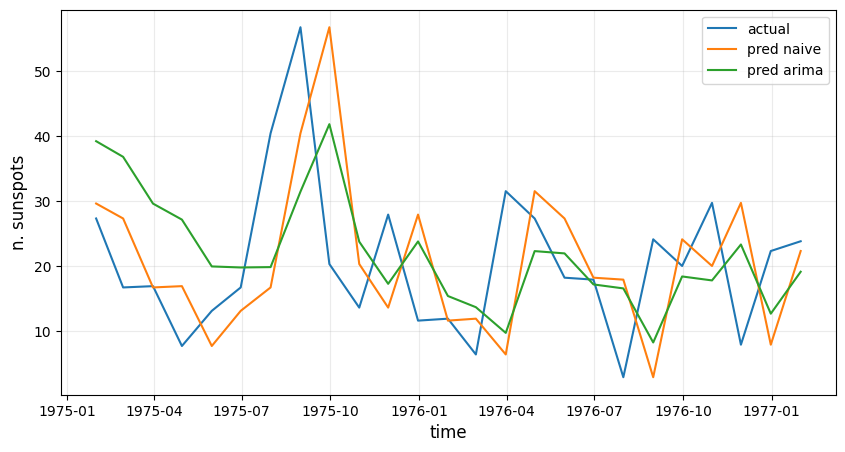

In [ ]:
start_idx = 100
end_idx = 125

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(test_df.index[start_idx:end_idx],inv_scale(test_df)[start_idx:end_idx], label='actual')
ax1.plot(test_df.index[start_idx:end_idx],inv_scale(test_df)[start_idx-1:end_idx-1], label='pred naive')
ax1.plot(inv_scale(preds)[start_idx:end_idx], label='pred arima')
ax1.set_ylabel('n. sunspots',fontsize=12)
ax1.set_xlabel('time',fontsize=12)
plt.legend()
plt.grid(alpha=0.25)
plt.show()

for `dynamic` parameter in `predict` method look [here](https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARIMA.predict.html#statsmodels.tsa.arima_model.ARIMA.predict)

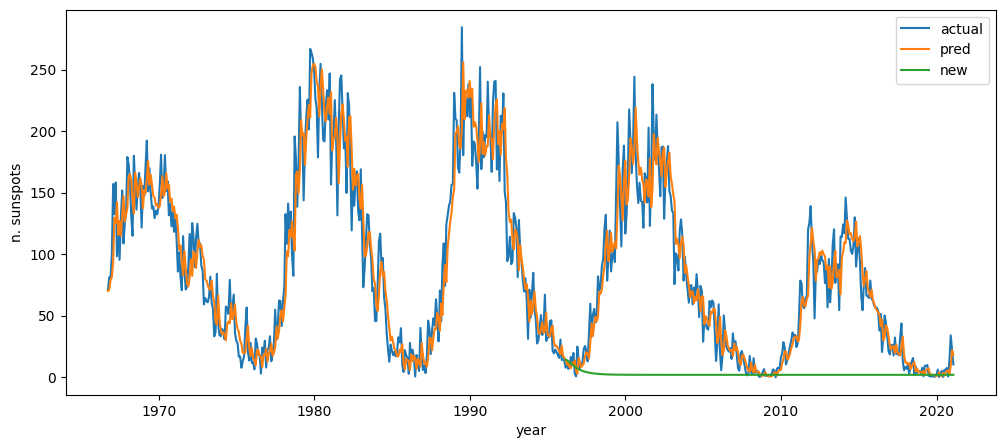

In [ ]:
# one-step prediction
y_pred = fit.predict(start=len(train_df), dynamic=False) #dynamic

# recursive prediction
n_last = 300
y_new = fit.predict(start=len(train_df) + len(test_df) - n_last, dynamic=True)

plt.figure(figsize=(12, 5))
plt.plot(inv_scale(test_df), label="actual")
plt.plot(inv_scale(y_pred), label="pred")
plt.plot(inv_scale(y_new), label="new")
plt.xlabel('year')
plt.ylabel('n. sunspots')
plt.legend()
plt.show()

Some final remarks on ARIMA(p,i,q) models:



1.   In the end, how do I choose p, i, q?
We can try to check goodness of fit based on metrics like AIC, BIC with several tests. Or you can use [auto.arima](https://github.com/alkaline-ml/pmdarima) packages.
2.   Can we do more? Yes!
*   we can take seasonality into account (SARIMA)
*   we can add exogenous variables (e.g., date, time of the year, some other useful predictor, ...) (ARIMAX)
*   we can combine the two (SARIMAX)








## Nonlinear Autoregressive models

From the theory:

$$ \hat{y}_t = f_\Theta (x_{t-1} + ... + x_{t-p})$$

with $y_t = x_t$ and $f_\Theta$ a nonlinear function.

### Let's divide data into windows

```
            historical data                   | future observations
--------------------------------------------------------------------
x(1) x(2) ... x(t-p) x(t-p+1) ... x(t-1) x(t) | x(t+1)  x(t+2) ...
                    \________________________/| \____/
                       time window            | value to
                                              | be predicted
```

In [ ]:
# Time windows
def get_time_windows(sequence, window_size):
    time = np.arange(sequence.shape[0])
    xseq = []
    yseq = []
    for t in time[:-window_size]:
        xseq.append(sequence[t:t+window_size])
        yseq.append(sequence[t+window_size]) # one-step prediction
    xseq = np.array(xseq)
    yseq = np.array(yseq)
    #train-test split
    return xseq, yseq.ravel()


In [ ]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)
print("training data", x_train.shape, y_train.shape)
print("test data", x_test.shape, y_test.shape)

training data (2588, 24) (2588,)
test data (629, 24) (629,)


We can use the usual syntax to build a neural network with pytorch and train it to predict the next value in the time-series.

We can formulate it as a regression problem.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class FFNN(nn.Module):
    def __init__(self, win_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(win_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

cpu


In [ ]:
model = FFNN(p).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

BATCH_SIZE = 64
n_epochs = 50

In [ ]:
trainset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                                          torch.tensor(y_train, dtype=torch.float32))
testset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                         torch.tensor(y_test, dtype=torch.float32))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [ ]:
def train(model, criterion, optimizer, train_loader, n_epochs, device):
    training_losses = []
    validation_losses = []

    for epoch in range(n_epochs):
        model.train()

        for x, y in train_loader:           # Access the training data
            optimizer.zero_grad()           # Zero the gradients
            x, y = x.to(device), y.to(device)
            y_pred = model(x)               # Forward passs

            loss = criterion(y_pred, y)
            loss.backward()                 # Compute the gradients
            optimizer.step()                # Update the weights

            training_losses.append(loss.item()) # Save the loss for plotting

    return training_losses

In [ ]:
training_losses = train(model, criterion, optimizer, train_loader, n_epochs, device)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

# Build a model
def get_model(win_size):
    model = Sequential()
    model.add(Dense(64, activation="relu", input_shape=(win_size,)))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)

# Train the model
model = get_model(p)
history = model.fit(x_train, y_train, epochs=50)

preds = model.predict(x_test).ravel()

mse = np.square(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MAE: {mae}")

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10, 8))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='train_loss', c='C0')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

plot_history(history)


In [ ]:
# Predictions
y_pred = model.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="actual")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="pred")
plt.legend()

It looks like that the NAR model is not very good.

Let's see what happens with recursive predictions.

In [ ]:
# Predict on our prediction
def predict_rec(n, model, x_init):
    p = x_init.shape[0]

    y_new = np.zeros(p+n)
    y_new[:p] = x_init.copy()

    for j in range(n):
        y_tmp = model.predict(y_new[j:j+p][None, ...])
        y_new[j+p] = y_tmp[-1,0]
    return y_new[p:]

In [ ]:
# one-step prediction
y_pred = model.predict(x_test)

# one-step prediction
n_last = 300
y_new = predict_rec(n=n_last, model=model, x_init=x_test[-n_last-1])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="ground truth")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="predicted")
plt.plot(np.arange(y_test.shape[0]-n_last, y_test.shape[0]), y_new, label="new")
plt.legend()

## Recurrent neural networks

Finally let's try out a more advanced architecture: SimpleRNN networks. Documentation [here](https://keras.io/api/layers/recurrent_layers/simple_rnn/)

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Build a model
def get_model(win_size):
    model = Sequential()
    model.add(Reshape((-1, 1), input_shape=(None,))) # [batch, time, features]
    model.add(SimpleRNN(16))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse")
    return model

Some weight initialization documentation: [Xavier](https://cs230.stanford.edu/section/4/#xavier-initialization), [Glorot](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [ ]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)

# Train the model
model = get_model(p)
model.fit(x_train, y_train, epochs=50)

preds = model.predict(x_test).ravel()

mse = np.square(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mse}")

mae = np.abs(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mae}")

In [ ]:
# Predictions
y_pred = model.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="actual")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="pred")
plt.legend()

In [ ]:
# Predict on our prediction
def predict_rec(n, model, x_init):
    p = x_init.shape[0]

    y_new = np.zeros(p+n)
    y_new[:p] = x_init.copy()

    for j in range(n):
        y_tmp = model.predict(y_new[:j+p][None, ...])  # the rnn can handle sequences of arbitrary lenght
        y_new[j+p] = y_tmp[-1,0]
    return y_new[p:]

In [ ]:
# one-step prediction
y_pred = model.predict(x_test)

# one-step prediction
n_last = 300
y_new = predict_rec(n=n_last, model=model, x_init=x_test[-n_last-1])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="ground truth")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="predicted")
plt.plot(np.arange(y_test.shape[0]-n_last, y_test.shape[0]), y_new, label="new")
plt.legend()

In [ ]:
# NOW TRY LSTM BY YOURSELF!

Many more things left to explore:

* take seasonality into account;
* add exogenous variables (e.g., date/time of the year/...);
* multi-step forecasting;
* try CNNs;
* ...

Give a look at [prophet](https://facebook.github.io/prophet/).

Want to learn more about forecasting? [This](https://otexts.com/fpp3/) is a good resource to start.